<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading in the MNIST dataset


In [3]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [4]:
print(train_dataset.data.shape)

torch.Size([60000, 28, 28])


In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [27]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [22]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x



class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size


        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

#Building a GAN model 

In [23]:

class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 128
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]



        # initialization of the generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function
        #self.BCE_loss = nn.SmoothL1Loss(beta=0.9)
        self.BCE_loss = nn.BCELoss().cuda()
        self.BCE_loss = nn.MSELoss()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()
               # x_ = x_.view(x_.size(0),-1)
                #z_ = z_.view(z_.size(0),-1)
                

         

                # update D network using 
                # 1. Set optimizer gradient to zero
                gan.D_optimizer.zero_grad()
                
                D_real = gan.D(x_)

                
                D_real_loss = gan.BCE_loss(D_real, gan.y_real_ )
                G_ = gan.G(z_)
                D_fake = gan.D(G_)
                D_fake_loss = gan.BCE_loss(D_fake, gan.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                # 3. Do back propagation to compute gradients
                D_loss.backward()
                # 4. Make a step of D_optimizer
                gan.D_optimizer.step()

                # 5. Set the current loss in self.train_hist['D_loss]
                gan.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                gan.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = gan.G(z_)
                D_fake = gan.D(G_)
                G_loss = gan.BCE_loss(D_fake, gan.y_real_)
                # 3. Do back propagation to compute gradients
                G_loss.backward()
                # 4. Make a step of G_optimizer
                gan.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                gan.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
    
                  
            # Visualize results
            with torch.no_grad():
                 visualize_results(self)
   

        print("Training finished!")

training start!!
Epoch: [ 1] [  50/ 468] D_loss: 0.33994460, G_loss: 0.39697242
Epoch: [ 1] [ 100/ 468] D_loss: 0.36341357, G_loss: 0.41782093
Epoch: [ 1] [ 150/ 468] D_loss: 0.33910426, G_loss: 0.32172686
Epoch: [ 1] [ 200/ 468] D_loss: 0.33884501, G_loss: 0.40754235
Epoch: [ 1] [ 250/ 468] D_loss: 0.29783612, G_loss: 0.41395804
Epoch: [ 1] [ 300/ 468] D_loss: 0.33714348, G_loss: 0.39957908
Epoch: [ 1] [ 350/ 468] D_loss: 0.31370908, G_loss: 0.40926653
Epoch: [ 1] [ 400/ 468] D_loss: 0.30625409, G_loss: 0.39891404
Epoch: [ 1] [ 450/ 468] D_loss: 0.32117409, G_loss: 0.41348052


<Figure size 72x720 with 0 Axes>

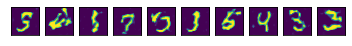

Epoch: [ 2] [  50/ 468] D_loss: 0.29221690, G_loss: 0.40389150
Epoch: [ 2] [ 100/ 468] D_loss: 0.34151390, G_loss: 0.38334650
Epoch: [ 2] [ 150/ 468] D_loss: 0.34708437, G_loss: 0.38945743
Epoch: [ 2] [ 200/ 468] D_loss: 0.33106881, G_loss: 0.35345721
Epoch: [ 2] [ 250/ 468] D_loss: 0.35217971, G_loss: 0.40407085
Epoch: [ 2] [ 300/ 468] D_loss: 0.30168706, G_loss: 0.42258996
Epoch: [ 2] [ 350/ 468] D_loss: 0.30979419, G_loss: 0.42258453
Epoch: [ 2] [ 400/ 468] D_loss: 0.29517829, G_loss: 0.45710304
Epoch: [ 2] [ 450/ 468] D_loss: 0.26904011, G_loss: 0.39945081


<Figure size 72x720 with 0 Axes>

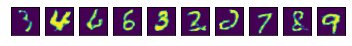

Epoch: [ 3] [  50/ 468] D_loss: 0.32845980, G_loss: 0.43468362
Epoch: [ 3] [ 100/ 468] D_loss: 0.41299385, G_loss: 0.46130887
Epoch: [ 3] [ 150/ 468] D_loss: 0.32009655, G_loss: 0.40519959
Epoch: [ 3] [ 200/ 468] D_loss: 0.27619869, G_loss: 0.47097224
Epoch: [ 3] [ 250/ 468] D_loss: 0.28667951, G_loss: 0.44866633
Epoch: [ 3] [ 300/ 468] D_loss: 0.34437466, G_loss: 0.34736332
Epoch: [ 3] [ 350/ 468] D_loss: 0.31307566, G_loss: 0.44049579
Epoch: [ 3] [ 400/ 468] D_loss: 0.35556799, G_loss: 0.43232188
Epoch: [ 3] [ 450/ 468] D_loss: 0.29257512, G_loss: 0.42221802


<Figure size 72x720 with 0 Axes>

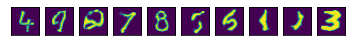

Epoch: [ 4] [  50/ 468] D_loss: 0.27930617, G_loss: 0.44515762
Epoch: [ 4] [ 100/ 468] D_loss: 0.29893184, G_loss: 0.43087679
Epoch: [ 4] [ 150/ 468] D_loss: 0.29268962, G_loss: 0.44626901
Epoch: [ 4] [ 200/ 468] D_loss: 0.36274618, G_loss: 0.45968813
Epoch: [ 4] [ 250/ 468] D_loss: 0.27291116, G_loss: 0.44036850
Epoch: [ 4] [ 300/ 468] D_loss: 0.29473919, G_loss: 0.49424806
Epoch: [ 4] [ 350/ 468] D_loss: 0.35866442, G_loss: 0.40563300
Epoch: [ 4] [ 400/ 468] D_loss: 0.28679186, G_loss: 0.43339479
Epoch: [ 4] [ 450/ 468] D_loss: 0.30286032, G_loss: 0.42374042


<Figure size 72x720 with 0 Axes>

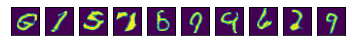

Epoch: [ 5] [  50/ 468] D_loss: 0.32896379, G_loss: 0.39201060
Epoch: [ 5] [ 100/ 468] D_loss: 0.32124007, G_loss: 0.43734929
Epoch: [ 5] [ 150/ 468] D_loss: 0.33387816, G_loss: 0.37847033
Epoch: [ 5] [ 200/ 468] D_loss: 0.35275799, G_loss: 0.38761136
Epoch: [ 5] [ 250/ 468] D_loss: 0.29247302, G_loss: 0.52106923
Epoch: [ 5] [ 300/ 468] D_loss: 0.31136316, G_loss: 0.35736543
Epoch: [ 5] [ 350/ 468] D_loss: 0.34130239, G_loss: 0.46685159
Epoch: [ 5] [ 400/ 468] D_loss: 0.32477468, G_loss: 0.44742560
Epoch: [ 5] [ 450/ 468] D_loss: 0.28461933, G_loss: 0.49354184


<Figure size 72x720 with 0 Axes>

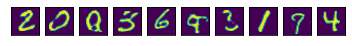

Epoch: [ 6] [  50/ 468] D_loss: 0.23532337, G_loss: 0.52647841
Epoch: [ 6] [ 100/ 468] D_loss: 0.28537619, G_loss: 0.46834350
Epoch: [ 6] [ 150/ 468] D_loss: 0.29072800, G_loss: 0.45890957
Epoch: [ 6] [ 200/ 468] D_loss: 0.35477307, G_loss: 0.38334334
Epoch: [ 6] [ 250/ 468] D_loss: 0.30910623, G_loss: 0.50696868
Epoch: [ 6] [ 300/ 468] D_loss: 0.33951551, G_loss: 0.42075810
Epoch: [ 6] [ 350/ 468] D_loss: 0.29152146, G_loss: 0.40993792
Epoch: [ 6] [ 400/ 468] D_loss: 0.38739133, G_loss: 0.43219438
Epoch: [ 6] [ 450/ 468] D_loss: 0.29142341, G_loss: 0.36012745


<Figure size 72x720 with 0 Axes>

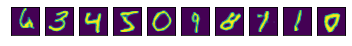

Epoch: [ 7] [  50/ 468] D_loss: 0.28984153, G_loss: 0.52335334
Epoch: [ 7] [ 100/ 468] D_loss: 0.24421144, G_loss: 0.44667357
Epoch: [ 7] [ 150/ 468] D_loss: 0.31058705, G_loss: 0.41121519
Epoch: [ 7] [ 200/ 468] D_loss: 0.31443581, G_loss: 0.41498554
Epoch: [ 7] [ 250/ 468] D_loss: 0.33116543, G_loss: 0.44622871
Epoch: [ 7] [ 300/ 468] D_loss: 0.27817756, G_loss: 0.47743160
Epoch: [ 7] [ 350/ 468] D_loss: 0.29911408, G_loss: 0.47872370
Epoch: [ 7] [ 400/ 468] D_loss: 0.26567894, G_loss: 0.50169146
Epoch: [ 7] [ 450/ 468] D_loss: 0.34667197, G_loss: 0.42488074


<Figure size 72x720 with 0 Axes>

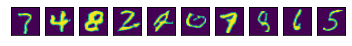

Epoch: [ 8] [  50/ 468] D_loss: 0.27398366, G_loss: 0.42848989
Epoch: [ 8] [ 100/ 468] D_loss: 0.30250242, G_loss: 0.40902981
Epoch: [ 8] [ 150/ 468] D_loss: 0.27161258, G_loss: 0.44837689
Epoch: [ 8] [ 200/ 468] D_loss: 0.26028764, G_loss: 0.53214645
Epoch: [ 8] [ 250/ 468] D_loss: 0.23649758, G_loss: 0.54003477
Epoch: [ 8] [ 300/ 468] D_loss: 0.31595027, G_loss: 0.47527170
Epoch: [ 8] [ 350/ 468] D_loss: 0.29316866, G_loss: 0.48795947
Epoch: [ 8] [ 400/ 468] D_loss: 0.25923669, G_loss: 0.42114598
Epoch: [ 8] [ 450/ 468] D_loss: 0.27755833, G_loss: 0.49599195


<Figure size 72x720 with 0 Axes>

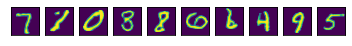

Epoch: [ 9] [  50/ 468] D_loss: 0.36722183, G_loss: 0.39638415
Epoch: [ 9] [ 100/ 468] D_loss: 0.27349448, G_loss: 0.52067959
Epoch: [ 9] [ 150/ 468] D_loss: 0.27934462, G_loss: 0.45571983
Epoch: [ 9] [ 200/ 468] D_loss: 0.24390671, G_loss: 0.58087885
Epoch: [ 9] [ 250/ 468] D_loss: 0.34013233, G_loss: 0.36241293
Epoch: [ 9] [ 300/ 468] D_loss: 0.26999813, G_loss: 0.57584310
Epoch: [ 9] [ 350/ 468] D_loss: 0.30683112, G_loss: 0.56896365
Epoch: [ 9] [ 400/ 468] D_loss: 0.33006948, G_loss: 0.43997791
Epoch: [ 9] [ 450/ 468] D_loss: 0.22408077, G_loss: 0.45865428


<Figure size 72x720 with 0 Axes>

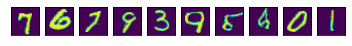

Epoch: [10] [  50/ 468] D_loss: 0.29900160, G_loss: 0.46858260
Epoch: [10] [ 100/ 468] D_loss: 0.26083052, G_loss: 0.52800715
Epoch: [10] [ 150/ 468] D_loss: 0.28463072, G_loss: 0.47556016
Epoch: [10] [ 200/ 468] D_loss: 0.27608642, G_loss: 0.61768770
Epoch: [10] [ 250/ 468] D_loss: 0.24494714, G_loss: 0.55297184
Epoch: [10] [ 300/ 468] D_loss: 0.18724430, G_loss: 0.53686255
Epoch: [10] [ 350/ 468] D_loss: 0.22432962, G_loss: 0.46040568
Epoch: [10] [ 400/ 468] D_loss: 0.22563536, G_loss: 0.39346716
Epoch: [10] [ 450/ 468] D_loss: 0.25569925, G_loss: 0.42631304


<Figure size 72x720 with 0 Axes>

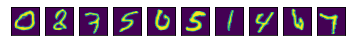

Epoch: [11] [  50/ 468] D_loss: 0.26695624, G_loss: 0.53569674
Epoch: [11] [ 100/ 468] D_loss: 0.24834381, G_loss: 0.56687248
Epoch: [11] [ 150/ 468] D_loss: 0.28890815, G_loss: 0.57744491
Epoch: [11] [ 200/ 468] D_loss: 0.27371174, G_loss: 0.37789249
Epoch: [11] [ 250/ 468] D_loss: 0.21035224, G_loss: 0.47290719
Epoch: [11] [ 300/ 468] D_loss: 0.21071559, G_loss: 0.45754069
Epoch: [11] [ 350/ 468] D_loss: 0.24179773, G_loss: 0.40305611
Epoch: [11] [ 400/ 468] D_loss: 0.33326808, G_loss: 0.38623762
Epoch: [11] [ 450/ 468] D_loss: 0.28690830, G_loss: 0.49957073


<Figure size 72x720 with 0 Axes>

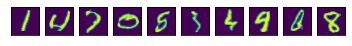

Epoch: [12] [  50/ 468] D_loss: 0.22624990, G_loss: 0.54003865
Epoch: [12] [ 100/ 468] D_loss: 0.32944167, G_loss: 0.58603823
Epoch: [12] [ 150/ 468] D_loss: 0.19779149, G_loss: 0.50529748
Epoch: [12] [ 200/ 468] D_loss: 0.32266402, G_loss: 0.53668886
Epoch: [12] [ 250/ 468] D_loss: 0.19694123, G_loss: 0.56183034
Epoch: [12] [ 300/ 468] D_loss: 0.28878373, G_loss: 0.52734923
Epoch: [12] [ 350/ 468] D_loss: 0.21807379, G_loss: 0.62413049
Epoch: [12] [ 400/ 468] D_loss: 0.21060535, G_loss: 0.47126710
Epoch: [12] [ 450/ 468] D_loss: 0.22969165, G_loss: 0.59385395


<Figure size 72x720 with 0 Axes>

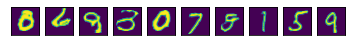

Epoch: [13] [  50/ 468] D_loss: 0.20966150, G_loss: 0.54380268
Epoch: [13] [ 100/ 468] D_loss: 0.21705145, G_loss: 0.63677758
Epoch: [13] [ 150/ 468] D_loss: 0.23208705, G_loss: 0.56679869
Epoch: [13] [ 200/ 468] D_loss: 0.20820977, G_loss: 0.56181008
Epoch: [13] [ 250/ 468] D_loss: 0.24846759, G_loss: 0.45445970
Epoch: [13] [ 300/ 468] D_loss: 0.19902788, G_loss: 0.49509221
Epoch: [13] [ 350/ 468] D_loss: 0.32204950, G_loss: 0.49363434
Epoch: [13] [ 400/ 468] D_loss: 0.21062902, G_loss: 0.53826696
Epoch: [13] [ 450/ 468] D_loss: 0.33194494, G_loss: 0.35239699


<Figure size 72x720 with 0 Axes>

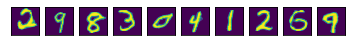

Epoch: [14] [  50/ 468] D_loss: 0.21516499, G_loss: 0.47182518
Epoch: [14] [ 100/ 468] D_loss: 0.24407786, G_loss: 0.55063128
Epoch: [14] [ 150/ 468] D_loss: 0.20866093, G_loss: 0.50202125
Epoch: [14] [ 200/ 468] D_loss: 0.22519353, G_loss: 0.55686307
Epoch: [14] [ 250/ 468] D_loss: 0.19706047, G_loss: 0.43383014
Epoch: [14] [ 300/ 468] D_loss: 0.25412256, G_loss: 0.42513162
Epoch: [14] [ 350/ 468] D_loss: 0.22572204, G_loss: 0.44526887
Epoch: [14] [ 400/ 468] D_loss: 0.26168495, G_loss: 0.52535301
Epoch: [14] [ 450/ 468] D_loss: 0.25080800, G_loss: 0.50247788


<Figure size 72x720 with 0 Axes>

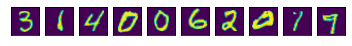

Epoch: [15] [  50/ 468] D_loss: 0.17508724, G_loss: 0.55228662
Epoch: [15] [ 100/ 468] D_loss: 0.16735449, G_loss: 0.62278360
Epoch: [15] [ 150/ 468] D_loss: 0.17578954, G_loss: 0.61773336
Epoch: [15] [ 200/ 468] D_loss: 0.19152258, G_loss: 0.60779786
Epoch: [15] [ 250/ 468] D_loss: 0.24070245, G_loss: 0.59891903
Epoch: [15] [ 300/ 468] D_loss: 0.23305219, G_loss: 0.40659365
Epoch: [15] [ 350/ 468] D_loss: 0.21015251, G_loss: 0.60728085
Epoch: [15] [ 400/ 468] D_loss: 0.27665129, G_loss: 0.52236307
Epoch: [15] [ 450/ 468] D_loss: 0.22464614, G_loss: 0.50046146


<Figure size 72x720 with 0 Axes>

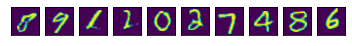

Epoch: [16] [  50/ 468] D_loss: 0.31227958, G_loss: 0.38163221
Epoch: [16] [ 100/ 468] D_loss: 0.16788086, G_loss: 0.43279862
Epoch: [16] [ 150/ 468] D_loss: 0.24638253, G_loss: 0.61465335
Epoch: [16] [ 200/ 468] D_loss: 0.20095780, G_loss: 0.56632733
Epoch: [16] [ 250/ 468] D_loss: 0.28501484, G_loss: 0.53784537
Epoch: [16] [ 300/ 468] D_loss: 0.25845426, G_loss: 0.50943875
Epoch: [16] [ 350/ 468] D_loss: 0.24666211, G_loss: 0.58013421
Epoch: [16] [ 400/ 468] D_loss: 0.22653812, G_loss: 0.61176777
Epoch: [16] [ 450/ 468] D_loss: 0.23977876, G_loss: 0.67938888


<Figure size 72x720 with 0 Axes>

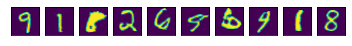

Epoch: [17] [  50/ 468] D_loss: 0.18032971, G_loss: 0.60020745
Epoch: [17] [ 100/ 468] D_loss: 0.16818200, G_loss: 0.58779740
Epoch: [17] [ 150/ 468] D_loss: 0.17640358, G_loss: 0.53253734
Epoch: [17] [ 200/ 468] D_loss: 0.21702251, G_loss: 0.50338155
Epoch: [17] [ 250/ 468] D_loss: 0.20876834, G_loss: 0.58534306
Epoch: [17] [ 300/ 468] D_loss: 0.16995595, G_loss: 0.61916256
Epoch: [17] [ 350/ 468] D_loss: 0.20538811, G_loss: 0.48057541
Epoch: [17] [ 400/ 468] D_loss: 0.22739980, G_loss: 0.56202418
Epoch: [17] [ 450/ 468] D_loss: 0.18361694, G_loss: 0.48246586


<Figure size 72x720 with 0 Axes>

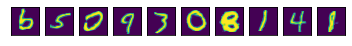

Epoch: [18] [  50/ 468] D_loss: 0.14237559, G_loss: 0.61054599
Epoch: [18] [ 100/ 468] D_loss: 0.15721087, G_loss: 0.60773051
Epoch: [18] [ 150/ 468] D_loss: 0.26820409, G_loss: 0.57769358
Epoch: [18] [ 200/ 468] D_loss: 0.14633331, G_loss: 0.57547319
Epoch: [18] [ 250/ 468] D_loss: 0.20321102, G_loss: 0.65604734
Epoch: [18] [ 300/ 468] D_loss: 0.21128874, G_loss: 0.53374362
Epoch: [18] [ 350/ 468] D_loss: 0.20595719, G_loss: 0.48831636
Epoch: [18] [ 400/ 468] D_loss: 0.20885396, G_loss: 0.47011542
Epoch: [18] [ 450/ 468] D_loss: 0.13326997, G_loss: 0.54744530


<Figure size 72x720 with 0 Axes>

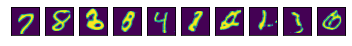

Epoch: [19] [  50/ 468] D_loss: 0.18287249, G_loss: 0.58222091
Epoch: [19] [ 100/ 468] D_loss: 0.22635862, G_loss: 0.64161003
Epoch: [19] [ 150/ 468] D_loss: 0.24343440, G_loss: 0.56253356
Epoch: [19] [ 200/ 468] D_loss: 0.32813239, G_loss: 0.37828839
Epoch: [19] [ 250/ 468] D_loss: 0.15469140, G_loss: 0.58698237
Epoch: [19] [ 300/ 468] D_loss: 0.19425744, G_loss: 0.46457812
Epoch: [19] [ 350/ 468] D_loss: 0.19009334, G_loss: 0.63958466
Epoch: [19] [ 400/ 468] D_loss: 0.20321366, G_loss: 0.65825653
Epoch: [19] [ 450/ 468] D_loss: 0.16151163, G_loss: 0.63616991


<Figure size 72x720 with 0 Axes>

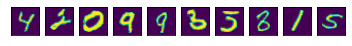

Epoch: [20] [  50/ 468] D_loss: 0.23669183, G_loss: 0.69351381
Epoch: [20] [ 100/ 468] D_loss: 0.24558604, G_loss: 0.46461037
Epoch: [20] [ 150/ 468] D_loss: 0.27503586, G_loss: 0.68536079
Epoch: [20] [ 200/ 468] D_loss: 0.22731203, G_loss: 0.71378559
Epoch: [20] [ 250/ 468] D_loss: 0.20748501, G_loss: 0.52027273
Epoch: [20] [ 300/ 468] D_loss: 0.19065891, G_loss: 0.57231092
Epoch: [20] [ 350/ 468] D_loss: 0.17538112, G_loss: 0.66917878
Epoch: [20] [ 400/ 468] D_loss: 0.27282205, G_loss: 0.62184328
Epoch: [20] [ 450/ 468] D_loss: 0.21038708, G_loss: 0.48142838


<Figure size 72x720 with 0 Axes>

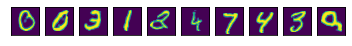

Epoch: [21] [  50/ 468] D_loss: 0.19107066, G_loss: 0.66757619
Epoch: [21] [ 100/ 468] D_loss: 0.14345455, G_loss: 0.59643531
Epoch: [21] [ 150/ 468] D_loss: 0.17510754, G_loss: 0.57804990
Epoch: [21] [ 200/ 468] D_loss: 0.17814851, G_loss: 0.71092421
Epoch: [21] [ 250/ 468] D_loss: 0.24872456, G_loss: 0.47779927
Epoch: [21] [ 300/ 468] D_loss: 0.14944287, G_loss: 0.62768650
Epoch: [21] [ 350/ 468] D_loss: 0.17116106, G_loss: 0.54090810
Epoch: [21] [ 400/ 468] D_loss: 0.16554853, G_loss: 0.59165674
Epoch: [21] [ 450/ 468] D_loss: 0.19571099, G_loss: 0.63603175


<Figure size 72x720 with 0 Axes>

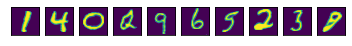

Epoch: [22] [  50/ 468] D_loss: 0.15703075, G_loss: 0.45371103
Epoch: [22] [ 100/ 468] D_loss: 0.18693340, G_loss: 0.65181887
Epoch: [22] [ 150/ 468] D_loss: 0.21312010, G_loss: 0.52927977
Epoch: [22] [ 200/ 468] D_loss: 0.20711648, G_loss: 0.59975976
Epoch: [22] [ 250/ 468] D_loss: 0.18242662, G_loss: 0.60108316
Epoch: [22] [ 300/ 468] D_loss: 0.23845325, G_loss: 0.58637214
Epoch: [22] [ 350/ 468] D_loss: 0.15847057, G_loss: 0.67273200
Epoch: [22] [ 400/ 468] D_loss: 0.24081576, G_loss: 0.64413667
Epoch: [22] [ 450/ 468] D_loss: 0.16145411, G_loss: 0.62737930


<Figure size 72x720 with 0 Axes>

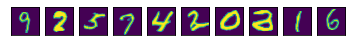

Epoch: [23] [  50/ 468] D_loss: 0.14979900, G_loss: 0.59649301
Epoch: [23] [ 100/ 468] D_loss: 0.20092320, G_loss: 0.61154079
Epoch: [23] [ 150/ 468] D_loss: 0.11914349, G_loss: 0.57822299
Epoch: [23] [ 200/ 468] D_loss: 0.18302627, G_loss: 0.53222764
Epoch: [23] [ 250/ 468] D_loss: 0.26639247, G_loss: 0.69093454
Epoch: [23] [ 300/ 468] D_loss: 0.16458458, G_loss: 0.68905640
Epoch: [23] [ 350/ 468] D_loss: 0.12623969, G_loss: 0.52044654
Epoch: [23] [ 400/ 468] D_loss: 0.16048282, G_loss: 0.52852190
Epoch: [23] [ 450/ 468] D_loss: 0.14224000, G_loss: 0.67543536


<Figure size 72x720 with 0 Axes>

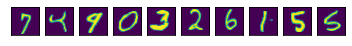

Epoch: [24] [  50/ 468] D_loss: 0.19680329, G_loss: 0.60474694
Epoch: [24] [ 100/ 468] D_loss: 0.17323460, G_loss: 0.53990376
Epoch: [24] [ 150/ 468] D_loss: 0.18635827, G_loss: 0.70866323
Epoch: [24] [ 200/ 468] D_loss: 0.17623119, G_loss: 0.56811017
Epoch: [24] [ 250/ 468] D_loss: 0.19810170, G_loss: 0.49556670
Epoch: [24] [ 300/ 468] D_loss: 0.16259453, G_loss: 0.65426612
Epoch: [24] [ 350/ 468] D_loss: 0.16487494, G_loss: 0.67395449
Epoch: [24] [ 400/ 468] D_loss: 0.18803158, G_loss: 0.51367211
Epoch: [24] [ 450/ 468] D_loss: 0.27025864, G_loss: 0.48778787


<Figure size 72x720 with 0 Axes>

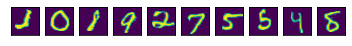

Epoch: [25] [  50/ 468] D_loss: 0.25687003, G_loss: 0.51538068
Epoch: [25] [ 100/ 468] D_loss: 0.14349160, G_loss: 0.68385780
Epoch: [25] [ 150/ 468] D_loss: 0.18875518, G_loss: 0.54579902
Epoch: [25] [ 200/ 468] D_loss: 0.16062367, G_loss: 0.64766258
Epoch: [25] [ 250/ 468] D_loss: 0.10177635, G_loss: 0.64337802
Epoch: [25] [ 300/ 468] D_loss: 0.14024946, G_loss: 0.64549994
Epoch: [25] [ 350/ 468] D_loss: 0.21252558, G_loss: 0.65775478
Epoch: [25] [ 400/ 468] D_loss: 0.15350147, G_loss: 0.69926721
Epoch: [25] [ 450/ 468] D_loss: 0.23183721, G_loss: 0.53467011


<Figure size 72x720 with 0 Axes>

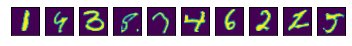

Epoch: [26] [  50/ 468] D_loss: 0.19851914, G_loss: 0.60994315
Epoch: [26] [ 100/ 468] D_loss: 0.14214653, G_loss: 0.62516510
Epoch: [26] [ 150/ 468] D_loss: 0.18335781, G_loss: 0.57160652
Epoch: [26] [ 200/ 468] D_loss: 0.23340799, G_loss: 0.70660388
Epoch: [26] [ 250/ 468] D_loss: 0.18113339, G_loss: 0.57316041
Epoch: [26] [ 300/ 468] D_loss: 0.33470446, G_loss: 0.61303043
Epoch: [26] [ 350/ 468] D_loss: 0.23056406, G_loss: 0.62624693
Epoch: [26] [ 400/ 468] D_loss: 0.16167198, G_loss: 0.48378515
Epoch: [26] [ 450/ 468] D_loss: 0.22709616, G_loss: 0.57244587


<Figure size 72x720 with 0 Axes>

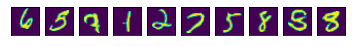

Epoch: [27] [  50/ 468] D_loss: 0.14354700, G_loss: 0.70092213
Epoch: [27] [ 100/ 468] D_loss: 0.21953800, G_loss: 0.68995625
Epoch: [27] [ 150/ 468] D_loss: 0.11181766, G_loss: 0.62918484
Epoch: [27] [ 200/ 468] D_loss: 0.11481139, G_loss: 0.63108152
Epoch: [27] [ 250/ 468] D_loss: 0.11925964, G_loss: 0.62602115
Epoch: [27] [ 300/ 468] D_loss: 0.14629607, G_loss: 0.61169410
Epoch: [27] [ 350/ 468] D_loss: 0.18492618, G_loss: 0.65872335
Epoch: [27] [ 400/ 468] D_loss: 0.17301899, G_loss: 0.70218885
Epoch: [27] [ 450/ 468] D_loss: 0.19934423, G_loss: 0.72457743


<Figure size 72x720 with 0 Axes>

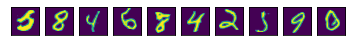

Epoch: [28] [  50/ 468] D_loss: 0.12839302, G_loss: 0.63592589
Epoch: [28] [ 100/ 468] D_loss: 0.20242287, G_loss: 0.53186810
Epoch: [28] [ 150/ 468] D_loss: 0.19649637, G_loss: 0.47475141
Epoch: [28] [ 200/ 468] D_loss: 0.16075347, G_loss: 0.49726957
Epoch: [28] [ 250/ 468] D_loss: 0.16280262, G_loss: 0.69893670
Epoch: [28] [ 300/ 468] D_loss: 0.19124553, G_loss: 0.70445991
Epoch: [28] [ 350/ 468] D_loss: 0.15701064, G_loss: 0.46944565
Epoch: [28] [ 400/ 468] D_loss: 0.31074673, G_loss: 0.43634269
Epoch: [28] [ 450/ 468] D_loss: 0.18142912, G_loss: 0.64401686


<Figure size 72x720 with 0 Axes>

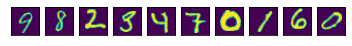

Epoch: [29] [  50/ 468] D_loss: 0.26371729, G_loss: 0.42684606
Epoch: [29] [ 100/ 468] D_loss: 0.11695611, G_loss: 0.69562161
Epoch: [29] [ 150/ 468] D_loss: 0.15909970, G_loss: 0.58615208
Epoch: [29] [ 200/ 468] D_loss: 0.16450971, G_loss: 0.50797999
Epoch: [29] [ 250/ 468] D_loss: 0.15397462, G_loss: 0.68021870
Epoch: [29] [ 300/ 468] D_loss: 0.13823055, G_loss: 0.59916556
Epoch: [29] [ 350/ 468] D_loss: 0.16363886, G_loss: 0.67628831
Epoch: [29] [ 400/ 468] D_loss: 0.12789160, G_loss: 0.59339923
Epoch: [29] [ 450/ 468] D_loss: 0.15392953, G_loss: 0.67602819


<Figure size 72x720 with 0 Axes>

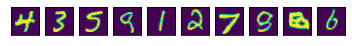

Epoch: [30] [  50/ 468] D_loss: 0.18538895, G_loss: 0.51619053
Epoch: [30] [ 100/ 468] D_loss: 0.12162875, G_loss: 0.58496290
Epoch: [30] [ 150/ 468] D_loss: 0.20287383, G_loss: 0.66111135
Epoch: [30] [ 200/ 468] D_loss: 0.11561194, G_loss: 0.71705353
Epoch: [30] [ 250/ 468] D_loss: 0.12406711, G_loss: 0.63610590
Epoch: [30] [ 300/ 468] D_loss: 0.14817604, G_loss: 0.70750916
Epoch: [30] [ 350/ 468] D_loss: 0.14083628, G_loss: 0.69096112
Epoch: [30] [ 400/ 468] D_loss: 0.24975988, G_loss: 0.54126060
Epoch: [30] [ 450/ 468] D_loss: 0.13717578, G_loss: 0.60894912


<Figure size 72x720 with 0 Axes>

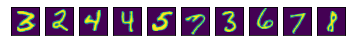

Training finished!


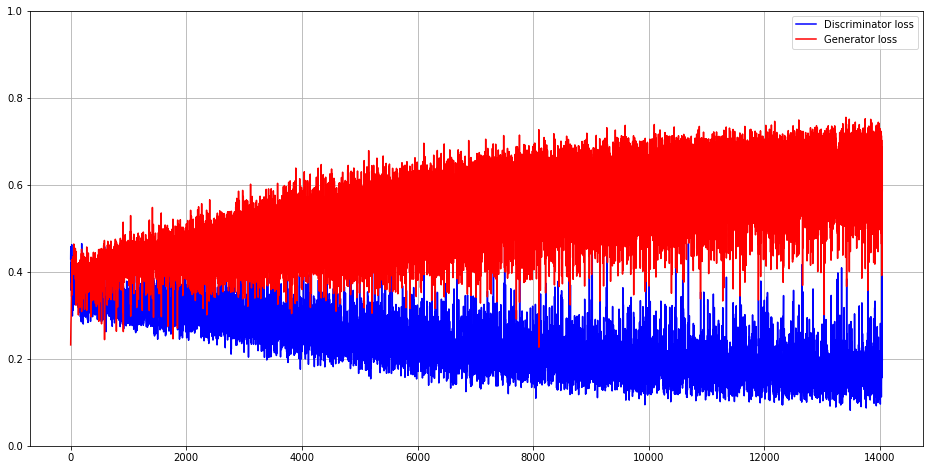

In [32]:
import time
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':30}
params['z_dim'] =16
params['base_size'] = 128

gan = GAN(params)
gan.train()